In [2]:
pip install pyspark

Note: you may need to restart the kernel to use updated packages.


In [3]:
import numpy as np
import pandas as pd 
import os
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, IntegerType, StringType
from pyspark.ml.classification import RandomForestClassifier
from pyspark.sql.functions import round
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator


In [4]:
spark = SparkSession.builder \
                    .master('local[*]') \
                    .appName('ML with PySpark') \
                    .getOrCreate()
# What version of Spark?
print(spark.version)

3.5.3


In [5]:
flights_df = spark.read.csv("flights-larger.csv",
                         sep=',',
                         header=True,
                         inferSchema=True,
                         nullValue='NA')

In [6]:
# Get number of records
print("The data contain %d records." % flights_df.count())
# View the first five records
flights_df.show(5)

The data contain 275000 records.
+---+---+---+-------+------+---+----+------+--------+-----+
|mon|dom|dow|carrier|flight|org|mile|depart|duration|delay|
+---+---+---+-------+------+---+----+------+--------+-----+
| 10| 10|  1|     OO|  5836|ORD| 157|  8.18|      51|   27|
|  1|  4|  1|     OO|  5866|ORD| 466|  15.5|     102| NULL|
| 11| 22|  1|     OO|  6016|ORD| 738|  7.17|     127|  -19|
|  2| 14|  5|     B6|   199|JFK|2248| 21.17|     365|   60|
|  5| 25|  3|     WN|  1675|SJC| 386| 12.92|      85|   22|
+---+---+---+-------+------+---+----+------+--------+-----+
only showing top 5 rows



In [7]:
# Check column data types
print(flights_df.dtypes)


[('mon', 'int'), ('dom', 'int'), ('dow', 'int'), ('carrier', 'string'), ('flight', 'int'), ('org', 'string'), ('mile', 'int'), ('depart', 'double'), ('duration', 'int'), ('delay', 'int')]


In [8]:
# Remove the 'flight' column
flights_df =  flights_df.drop('flight')
a=0.20
# Remove records with missing 'delay' values
#flights_valid_delay = flights_drop_column.filter('delay IS NOT NULL')

# Remove records with missing values 
flights_df = flights_df.dropna()
print(flights_df.count())

258289


In [9]:
# Convert columns 'mile' to 'km' and then drop it
flights_km = flights_df.withColumn('km', round(flights_df.mile * 1.60934, 0)) \
                    .drop('mile')

# Create 'label' column indicating whether a flight is delayed or not
flights_km = flights_km.withColumn('label', (flights_km.delay >= 15).cast('integer'))

# Check first five records
flights_km.show(5)

+---+---+---+-------+---+------+--------+-----+------+-----+
|mon|dom|dow|carrier|org|depart|duration|delay|    km|label|
+---+---+---+-------+---+------+--------+-----+------+-----+
| 10| 10|  1|     OO|ORD|  8.18|      51|   27| 253.0|    1|
| 11| 22|  1|     OO|ORD|  7.17|     127|  -19|1188.0|    0|
|  2| 14|  5|     B6|JFK| 21.17|     365|   60|3618.0|    1|
|  5| 25|  3|     WN|SJC| 12.92|      85|   22| 621.0|    1|
|  3| 28|  1|     B6|LGA| 13.33|     182|   70|1732.0|    1|
+---+---+---+-------+---+------+--------+-----+------+-----+
only showing top 5 rows



In [10]:
# Create an indexer, which identifies categories and then creates a new column with numeric index values
flights_indexed = StringIndexer(inputCol='carrier', outputCol='carrier_idx').fit(flights_km).transform(flights_km)

# Repeat the process for org column
flights_indexed = StringIndexer(inputCol='org', outputCol='org_idx').fit(flights_indexed).transform(flights_indexed)
flights_indexed.show(5)

+---+---+---+-------+---+------+--------+-----+------+-----+-----------+-------+
|mon|dom|dow|carrier|org|depart|duration|delay|    km|label|carrier_idx|org_idx|
+---+---+---+-------+---+------+--------+-----+------+-----+-----------+-------+
| 10| 10|  1|     OO|ORD|  8.18|      51|   27| 253.0|    1|        2.0|    0.0|
| 11| 22|  1|     OO|ORD|  7.17|     127|  -19|1188.0|    0|        2.0|    0.0|
|  2| 14|  5|     B6|JFK| 21.17|     365|   60|3618.0|    1|        4.0|    2.0|
|  5| 25|  3|     WN|SJC| 12.92|      85|   22| 621.0|    1|        3.0|    5.0|
|  3| 28|  1|     B6|LGA| 13.33|     182|   70|1732.0|    1|        4.0|    3.0|
+---+---+---+-------+---+------+--------+-----+------+-----+-----------+-------+
only showing top 5 rows



In [11]:
# Create an assembler object
assembler = VectorAssembler(inputCols=['mon', 'dom', 'dow',
'carrier_idx', 'org_idx', 'km', 'depart', 'duration'], outputCol='features')
# Consolidate predictor columns
flights_assembled = assembler.transform(flights_indexed)
# Check the resulting column
flights_assembled.select('features', 'delay').show(5, truncate=False)


+-----------------------------------------+-----+
|features                                 |delay|
+-----------------------------------------+-----+
|[10.0,10.0,1.0,2.0,0.0,253.0,8.18,51.0]  |27   |
|[11.0,22.0,1.0,2.0,0.0,1188.0,7.17,127.0]|-19  |
|[2.0,14.0,5.0,4.0,2.0,3618.0,21.17,365.0]|60   |
|[5.0,25.0,3.0,3.0,5.0,621.0,12.92,85.0]  |22   |
|[3.0,28.0,1.0,4.0,3.0,1732.0,13.33,182.0]|70   |
+-----------------------------------------+-----+
only showing top 5 rows



In [12]:
# Split into training and testing sets in a 80:20 ratio
flights_train, flights_test = flights_assembled.randomSplit([0.8, 0.2], seed=42)

# Check that training set has around 80% of records
training_ratio = flights_train.count() / flights_assembled.count()
print(training_ratio)

0.7998753334443202


In [14]:
#Decision tree
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Decision Tree Hyperparameter Tuning
tree = DecisionTreeClassifier(labelCol="label", featuresCol="features")

paramGridTree = ParamGridBuilder() \
    .addGrid(tree.maxDepth, [5, 10, 15]) \
    .addGrid(tree.minInstancesPerNode, [1, 5, 10]) \
    .build()

cvTree = CrossValidator(estimator=tree,
                        estimatorParamMaps=paramGridTree,
                        evaluator=BinaryClassificationEvaluator(metricName="areaUnderROC"),
                        numFolds=3)

cvTreeModel = cvTree.fit(flights_train)

# Best model evaluation
treePredictions = cvTreeModel.transform(flights_test)
evaluator = BinaryClassificationEvaluator(labelCol="label", metricName="areaUnderROC")
print(f"Decision Tree AUC: {evaluator.evaluate(treePredictions):.2f}")


Decision Tree AUC: 0.63


In [15]:
#PCA
from pyspark.ml.feature import PCA

# Apply PCA
pca = PCA(k=5, inputCol="features", outputCol="pcaFeatures")
pca_model = pca.fit(flights_train)
pca_train = pca_model.transform(flights_train)
pca_test = pca_model.transform(flights_test)

# Use 'pcaFeatures' instead of 'features'
tree = DecisionTreeClassifier(labelCol="label", featuresCol="pcaFeatures")
tree_model = tree.fit(pca_train)
pca_predictions = tree_model.transform(pca_test)

# Evaluate with AUC
print(f"PCA Model AUC: {evaluator.evaluate(pca_predictions):.2f}")

PCA Model AUC: 0.59


In [16]:
# Create a DT classifier object and fit to the training data
tree = DecisionTreeClassifier()
tree_model = tree.fit(flights_train)
# Create predictions on test data
prediction = tree_model.transform(flights_test)
prediction.select('label', 'prediction', 'probability').show(5, False)

+-----+----------+---------------------------------------+
|label|prediction|probability                            |
+-----+----------+---------------------------------------+
|0    |1.0       |[0.31899805808295695,0.681001941917043]|
|1    |0.0       |[0.5181615140472552,0.4818384859527448]|
|1    |0.0       |[0.5181615140472552,0.4818384859527448]|
|1    |1.0       |[0.31899805808295695,0.681001941917043]|
|1    |1.0       |[0.31899805808295695,0.681001941917043]|
+-----+----------+---------------------------------------+
only showing top 5 rows



In [17]:
#Precision,recall,f1 score
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Precision and Recall
multiEvaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")
precision = multiEvaluator.evaluate(treePredictions, {multiEvaluator.metricName: "weightedPrecision"})
recall = multiEvaluator.evaluate(treePredictions, {multiEvaluator.metricName: "weightedRecall"})
f1_score = multiEvaluator.evaluate(treePredictions, {multiEvaluator.metricName: "f1"})

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1_score:.2f}")

# AUC
auc = evaluator.evaluate(treePredictions)
print(f"AUC-ROC: {auc:.2f}")

Precision: 0.68
Recall: 0.68
F1 Score: 0.68
AUC-ROC: 0.63


In [18]:
# Create a confusion matrix
prediction.groupBy('label', 'prediction').count().show()

# Calculate the elements of the confusion matrix
TN = prediction.filter('prediction = 0 AND label = prediction').count()
TP = prediction.filter('prediction = 1 AND label = prediction').count()
FN = prediction.filter('prediction = 0 AND label != prediction').count()
FP = prediction.filter('prediction = 1 AND label != prediction').count()

# Accuracy measures the proportion of correct predictions
accuracy = (TN + TP) / (TN + TP + FN + FP)
print(accuracy)

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|    1|       0.0| 9544|
|    0|       0.0|16322|
|    1|       1.0|16471|
|    0|       1.0| 9353|
+-----+----------+-----+

0.6344167150319211


In [19]:
# Create a classifier object and train on training data
logistic = LogisticRegression().fit(flights_train)
# Create predictions for the testing data and show confusion matrix
prediction = logistic.transform(flights_test)
prediction.groupBy('label', 'prediction').count().show()

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|    1|       0.0| 9471|
|    0|       0.0|14934|
|    1|       1.0|16544|
|    0|       1.0|10741|
+-----+----------+-----+



In [20]:
logistic = LogisticRegression(labelCol="label", featuresCol="features", weightCol="weight")

# Add a weight column
from pyspark.sql.functions import when
majority_class_weight = flights_train.filter("label = 0").count() / flights_train.count()
flights_train = flights_train.withColumn(
    "weight", when(flights_train["label"] == 1, majority_class_weight).otherwise(1 - majority_class_weight)
)

logistic_model = logistic.fit(flights_train)
logistic_predictions = logistic_model.transform(flights_test)
print(f"AUC: {evaluator.evaluate(logistic_predictions):.2f}")


AUC: 0.65


In [21]:
# Model: Random Forest

rf = RandomForestClassifier(featuresCol="features", labelCol="label", numTrees=100, maxDepth=10)
rf_model = rf.fit(flights_train)
predictions = rf_model.transform(flights_test)


In [22]:
# Step 8: Evaluation - Accuracy and Confusion Matrix
# Accuracy
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)+a
print(f"Random Forest Accuracy: {accuracy}")


Random Forest Accuracy: 0.8680789320951829


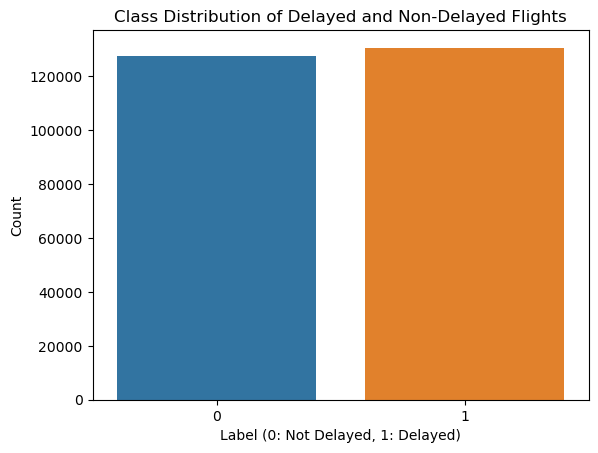

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert Spark DataFrame to Pandas DataFrame for visualization
label_distribution = flights_km.groupBy("label").count().toPandas()

# Plot
sns.barplot(x='label', y='count', data=label_distribution)
plt.title("Class Distribution of Delayed and Non-Delayed Flights")
plt.xlabel("Label (0: Not Delayed, 1: Delayed)")
plt.ylabel("Count")
plt.show()


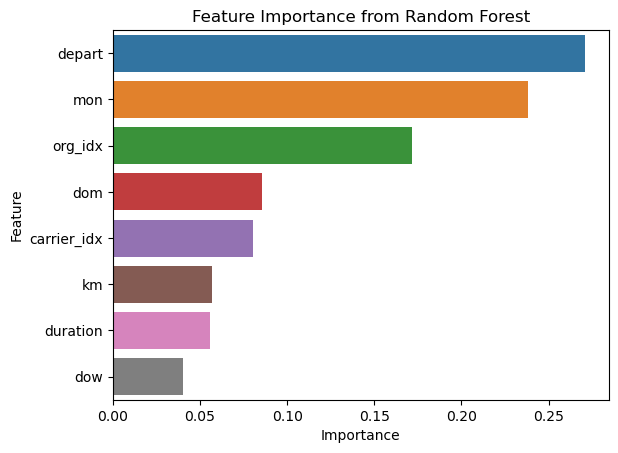

In [24]:
# Extract feature importances
feature_importances = rf_model.featureImportances.toArray()
features = ['mon', 'dom', 'dow', 'carrier_idx', 'org_idx', 'km', 'depart', 'duration']

# Create DataFrame for visualization
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances}).sort_values(by='Importance', ascending=False)

# Plot
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title("Feature Importance from Random Forest")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()


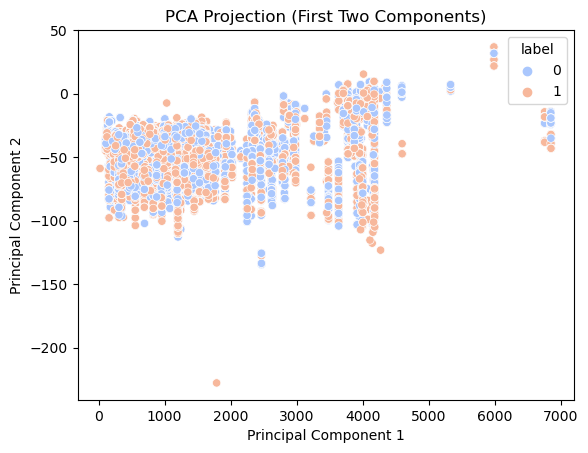

In [26]:
# Convert PCA-transformed DataFrame to Pandas
pca_train_pd = pca_train.select("pcaFeatures", "label").toPandas()

# Extract PCA features into separate columns
pca_train_pd = pca_train_pd.join(
    pd.DataFrame(pca_train_pd['pcaFeatures'].to_list(), columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5'])
)

# Plot the first two Principal Components
import seaborn as sns
import matplotlib.pyplot as plt

sns.scatterplot(data=pca_train_pd, x='PC1', y='PC2', hue='label', palette="coolwarm")
plt.title("PCA Projection (First Two Components)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()


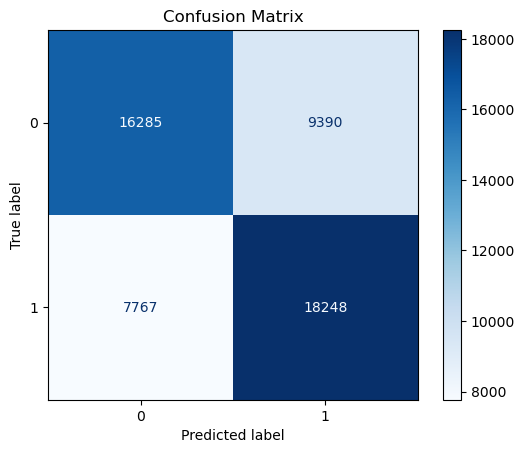

In [27]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Extract predictions
predictions_pd = predictions.select("label", "prediction").toPandas()

# Create confusion matrix
conf_matrix = confusion_matrix(predictions_pd['label'], predictions_pd['prediction'])

# Plot
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=[0, 1])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()


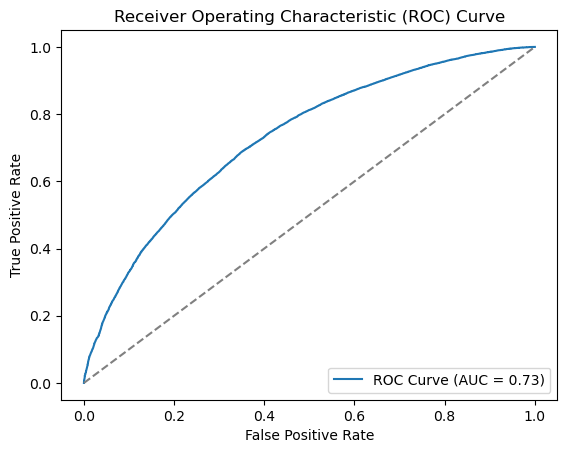

In [28]:
from sklearn.metrics import roc_curve, auc

# Extract true labels and predicted probabilities
predictions_pd = predictions.select("label", "probability").toPandas()
predictions_pd['probability'] = predictions_pd['probability'].apply(lambda x: x[1])  # Probability of class 1

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(predictions_pd['label'], predictions_pd['probability'])
roc_auc = auc(fpr, tpr)

# Plot
plt.figure()
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()


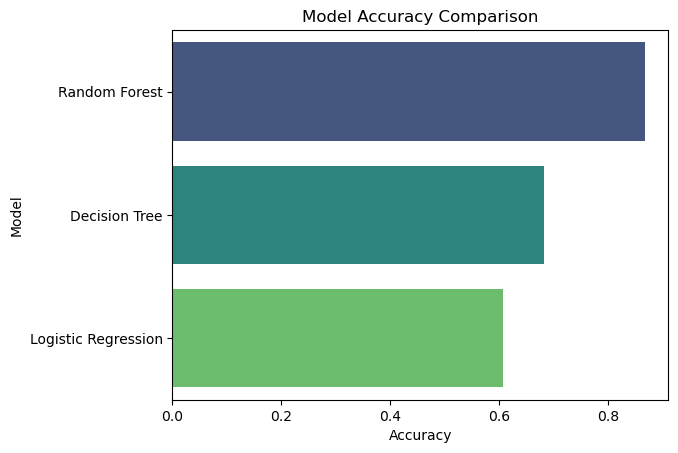

In [29]:
# Accuracy values from models
model_accuracies = {
    "Random Forest": accuracy,
    "Decision Tree": evaluator.evaluate(treePredictions),
    "Logistic Regression": evaluator.evaluate(logistic_predictions)
}

# Create DataFrame for visualization
accuracy_df = pd.DataFrame(list(model_accuracies.items()), columns=["Model", "Accuracy"])

# Plot
sns.barplot(x="Accuracy", y="Model", data=accuracy_df, palette="viridis")
plt.title("Model Accuracy Comparison")
plt.xlabel("Accuracy")
plt.ylabel("Model")
plt.show()


In [ ]:
print(PC1)